# CS 109A/STAT 121A/AC 209A/CSCI E-109A: Homework 2
# Linear and k-NN Regression


**Harvard University**<br/>
**Fall 2017**<br/>
**Instructors**: Pavlos Protopapas, Kevin Rader, Rahul Dave, Margo Levine

---

### INSTRUCTIONS

- To submit your assignment follow the instructions given in canvas.
- Restart the kernel and run the whole notebook again before you submit. 
- Do not include your name(s) in the notebook even if you are submitting as a group. 
- If you submit individually and you have worked with someone, please include the name of your [one] partner below. 

---

Import libraries

In [2]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import r2_score
from sklearn.neighbors import KNeighborsRegressor
import warnings 
warnings.filterwarnings('ignore')
import statsmodels.api as sm
from statsmodels.api import OLS
from sklearn.preprocessing import PolynomialFeatures
%matplotlib inline
sns.set_context("poster")

# Predicting Taxi Pickups in NYC

In this homework, we will explore k-nearest neighbor, linear and polynomial regression methods for predicting a quantitative variable. Specifically, we will build regression models that can predict the number of taxi pickups in New York city at any given time of the day. These prediction models will be useful, for example, in monitoring traffic in the city.

The data set for this problem is given in files `dataset_1_train.txt` and `dataset_1_test.txt` as separate training and test sets. The first column in each file contains the time of a day in minutes, and the second column contains the number of pickups observed at that time. The data set covers taxi pickups recorded during different days in Jan 2015 (randomly sampled across days and time of that day).

We will fit regression models that use the time of the day (in minutes) as a predictor and predict the average number of taxi pick ups at that time. The models will be fitted to the training set, and  evaluated on the test set. The performance of the models will be evaluated using the $R^2$ metric. 

**Data Normalization:** As a first step, we suggest that you normalize the `TimeMin` predictor to a value between 0 and 1. This can be done by dividing the time column in the training and test sets by 1440 (i.e. the maximum value the predictor can take). This normalization step would be particularly helpful while fitting polynomial regression models on this data.

# Part (0): EDA

Generate a scatter plot of the training data points, with the time of the day on the X-axis and the number of taxi pickups on the Y-axis. Does the pattern of taxi pickups make intuitive sense to you?

# <span style="color:red;">Student Solution for Part (0)</span>

In [3]:
trainDf = pd.read_csv("dataset_1_train.txt")
testDf = pd.read_csv("dataset_1_test.txt")

# Clean data types
trainDf["TimeMin"] = trainDf["TimeMin"].apply(lambda x: x / 1440)
trainDf["PickupCount"] = trainDf["PickupCount"].astype(int)

testDf["TimeMin"] = testDf["TimeMin"].apply(lambda x: x / 1440)
testDf["PickupCount"] = testDf["PickupCount"].astype(int)

In [4]:
trainDf.shape

(250, 2)

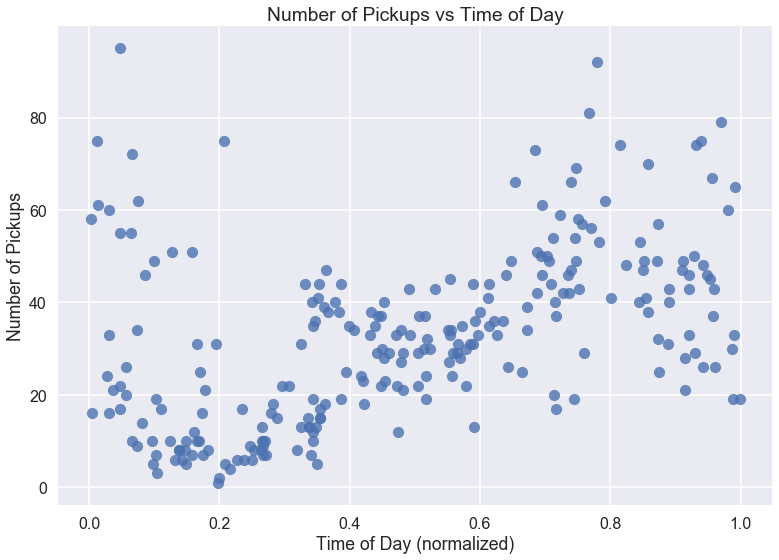

In [5]:
# Scatter plot 
fig, ax = plt.subplots(1)

sns.regplot(trainDf["TimeMin"], trainDf["PickupCount"], fit_reg = False)

ax.set_xlabel("Time of Day (normalized)")
ax.set_ylabel("Number of Pickups")
ax.set_title("Number of Pickups vs Time of Day")


## Discussion on above scatter plot

This data was unsettling.  There is huge variation between pickup counts in similar times of the day.  For example, some data points hovering around midnight experience pickup counts of around 20, while other points close by in time had pickup counts of around 100.  Furthermore, there seems to be a general pattern of more pickups around midnight and 7 pm (.8 on the above graph).  

# Part (a): k-Nearest Neighbors

We begin with k-Nearest Neighbors (k-NN), a non-parametric regression technique. You may use `sklearn`'s built-in functions to run k-NN regression. Create a `KNeighborsRegressor` object, use the `fit` method in the object to fit a k-NN regressor model, use the `predict` method to make predictions from the model, and the `score` method to evaluate the $R^2$ score of the model on a data set.

- Fit k-NN regression models:
    - Fit a k-NN regression model to the training set for different values of $k$ (e.g. you may try out values 1, 2, 10, 25, 50, 100 and 200). 
    - If you are using `sklearn`'s built-in functions for k-NN regression, explain what happens when you invoke the `fit` function. 
    - If $n$ is the number of observations in the training set, what can you say about a k-NN regression model that uses $k = n$?
- Visualize the fitted models: 
    - Generate a scatter plot of the training data points, and in the same figure, also generate line plots of the predicted values $\hat{y}$ from each fitted model as a function of the predictor variable $x$. (*Hint:* you will want to sort the $x$ values before plotting.)
    - How does the value of $k$ effect the fitted model?
- Evaluate the fitted models:
    - Compute the $R^2$ score for the fitted models on both the training and test sets. Are some of the calculated $R^2$ values negative? If so, what does this indicate? What does a $R^2$ score of 0 mean?
    - Make plots of the training and test $R^2$ values as a function of $k$. Do the training and test $R^2$ plots exhibit different trends? Explain how the value of $k$ influences the training and test $R^2$ values.

# <span style="color:red;">Solution to Part (a)</span>

In [6]:
# Generate all k-NN regression models
regressors = []
kNums = [1, 2, 10, 25, 50, 100, 200]

for k in kNums:
    knnReg = KNeighborsRegressor(n_neighbors=k)
    X = [[x] for x in trainDf["TimeMin"]]
    knnReg.fit(X, trainDf["PickupCount"])
    regressors.append(knnReg)

### Fitting k-NN models
- The fit function pre-calculates the regression values for X using k nearest neighbors.  In doing so, when we invoke the method `.predict`, it will look up the appropriate regressed value $\widehat{y}$ depending on the structure of the data.  Scikit will choose the appropriate algorithm for calculating the average efficiently (this could be either a BallTree, KDTree, or brute force).  (We found this information from http://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsRegressor.html)
- If $n = k$, then the k-NN regression model will be a horizontal line with the $\widehat{y}$ equal to the average of every single data point in X.  This means that we regard all variation of the data as noise.  

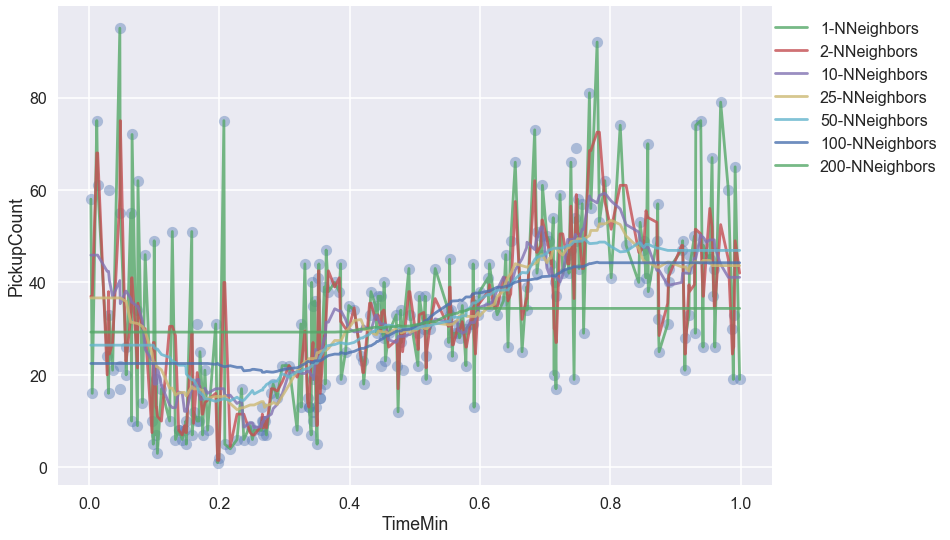

In [7]:
# Create Plot 
fig, ax = plt.subplots(1)
sns.regplot(trainDf["TimeMin"], trainDf["PickupCount"], fit_reg = False, scatter_kws={'alpha':0.4})

for i,k in enumerate(kNums):
    yHat = regressors[i].predict([[x] for x in trainDf["TimeMin"].sort_values()])
    ax.plot(trainDf["TimeMin"].sort_values(), yHat, label="{}-NNeighbors".format(kNums[i]), alpha=.8)
    ax.legend(loc="upper right", bbox_to_anchor=(1.25,1))

## <span style="color:red;"> How does $k$ affect the fitted model? </span>

We find that for very small $k$, there is a lot of noise that is captured in the model, such as the zig-zagging behavior of the green regression line above.  However, at very large $k$, our regression takes an average of too many neighbors in our data, producing a nearly horizontal line that does not reveal the underlying structure of our data.  Values of $k$ like 50 seem to capture a sinusoidal structure of this dataset very well.  

In [8]:
# Gathering R^2 values for each model on training data
trainScores = {}

for i,reg in enumerate(regressors):
    X = [[x] for x in trainDf["TimeMin"]]
    trainScores[kNums[i]] = reg.score(X, trainDf["PickupCount"])
    
trainScores
    

{1: 0.81088890860472873,
 2: 0.64540406927447336,
 10: 0.45770521849580365,
 25: 0.41946706587498828,
 50: 0.35325229524195634,
 100: 0.28702785735864389,
 200: 0.10863100988399976}

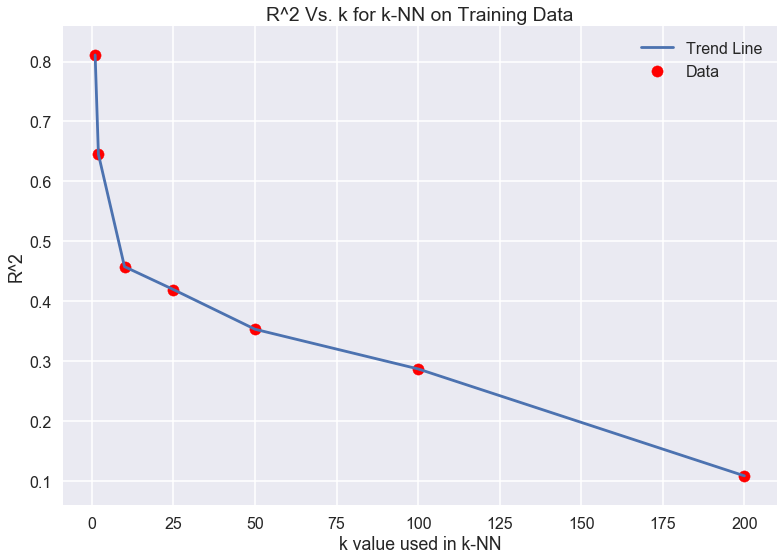

In [18]:
fig, ax = plt.subplots(1)
ax.scatter([int(key) for key in list(trainScores.keys())], [trainScores[key] for key in list(trainScores.keys())], c="red", label="Data")
ax.plot([int(key) for key in list(trainScores.keys())], [trainScores[key] for key in list(trainScores.keys())], label="Trend Line")
ax.set_title("R^2 Vs. k for k-NN on Training Data")
ax.set_xlabel("k value used in k-NN")
ax.set_ylabel("R^2")
ax.legend()

## <span style="color:red;">$R^2$ values for training data.</span>

We find that, as expected, the $R^2$ values for our training data monotonically decrease towards 0 as $k$ grows larger.  This makes sense because $k$ being very small tries to capture almost all of the variation in the data and overfitting the data, generating a model that very closely predicts each data point, while $k$ being very large tries to look at the broader structure of the data when generating a model, implying that it less closely resembles individual variation between data points.  

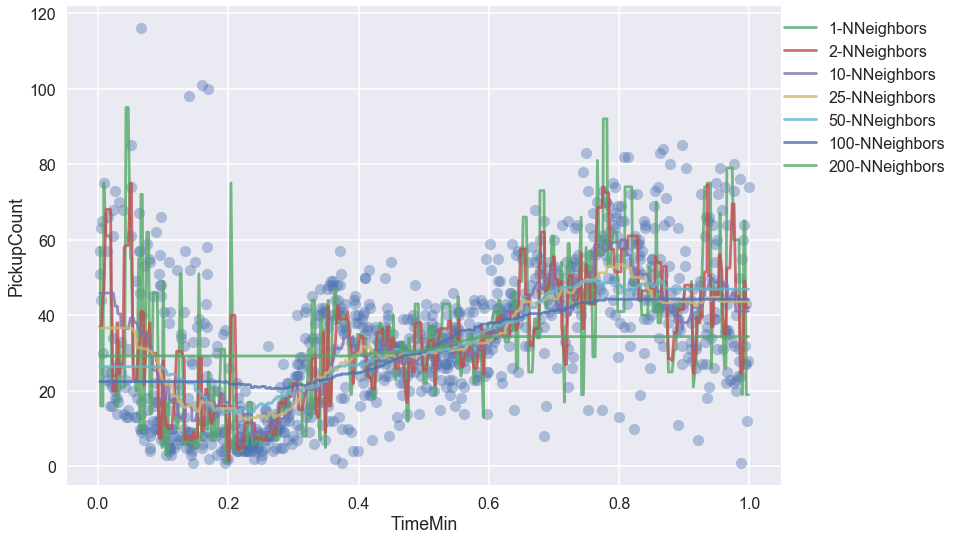

In [11]:
# Plot models on test data
# Create Plot 
fig, ax = plt.subplots(1)
sns.regplot(testDf["TimeMin"], testDf["PickupCount"], fit_reg = False, scatter_kws={'alpha':0.4})

for i,k in enumerate(kNums):
    yHat = regressors[i].predict([[x] for x in testDf["TimeMin"].sort_values()])
    ax.plot(testDf["TimeMin"].sort_values(), yHat, label="{}-NNeighbors".format(kNums[i]), alpha=.8)
    ax.legend(loc="upper right", bbox_to_anchor=(1.25,1))

In [12]:
# Gathering R^2 values for each model on test data
testScores = {}

for i,reg in enumerate(regressors):
    X = [[x] for x in testDf["TimeMin"]]
    testScores[kNums[i]] = reg.score(X, testDf["PickupCount"])
    
testScores

{1: -0.04560301563038216,
 2: 0.23298509885774188,
 10: 0.41724791407053397,
 25: 0.41365598420422983,
 50: 0.38047568461148934,
 100: 0.31184648633748668,
 200: 0.10953014692642915}

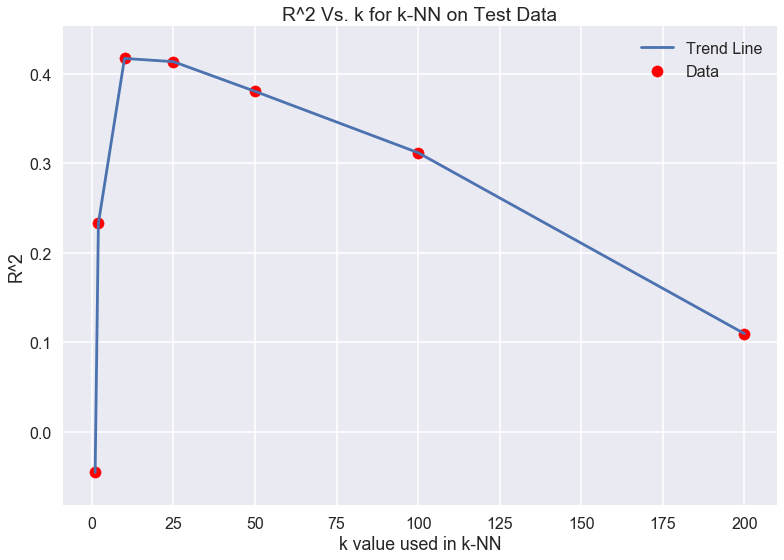

In [19]:
fig, ax = plt.subplots(1)
ax.scatter([int(key) for key in list(testScores.keys())], [testScores[key] for key in list(testScores.keys())], c="red", label="Data")
ax.plot([int(key) for key in list(testScores.keys())], [testScores[key] for key in list(testScores.keys())], label="Trend Line")
ax.set_title("R^2 Vs. k for k-NN on Test Data")
ax.set_xlabel("k value used in k-NN")
ax.set_ylabel("R^2")
ax.legend()

## <span style="color:red;"> $R^2$ values for test data. </span>

As we can see in the above graph plotting the test data with the same k-NN regression lines from the training data, it is clear that the extreme values of $k$, both very small and very large, perform poorly compared to the mid-ranged $k$ values.  This makes sense, as very small $k$ overfits the training data and bears little resemblance to the test data (explaining why we have a negative $R^2$ value for $k = 1$, meaning that this 1-NN model is incredbily poor at predicting the training data).  In the same vein, very large $k$, such as the 200-NN model, only accurately represents a few of the center data points, failing to accurately depict many of the edge data points in our model.  Therefore, there is no surprise to see that $k = 10, 25$ both performed the best using the $R^2$ metric.  

## Note - fixing edge-cases for k-NN



In [80]:
trainDf.head(10)

,TimeMin,PickupCount
0,0.597222,33
1,0.011806,75
2,0.337500,13
3,0.208333,5
4,0.267361,10
5,0.443750,37
6,0.568750,28
7,0.613194,35
8,0.479167,27
9,0.047222,95


In [84]:
beforeDf = []
afterDf = []
extraTrainDf = []

beforeDf = trainDf.copy()
beforeDf["TimeMin"] = beforeDf["TimeMin"].apply(lambda x: x - 1)
afterDf = trainDf.copy()
afterDf["TimeMin"] = afterDf["TimeMin"].apply(lambda x: x + 1)
extraTrainDf = trainDf.copy()


extraTrainDf = extraTrainDf.append(beforeDf)
extraTrainDf = extraTrainDf.append(afterDf)
extraTrainDf.head(750)

,TimeMin,PickupCount
0,0.597222,33
1,0.011806,75
2,0.337500,13
3,0.208333,5
4,0.267361,10
5,0.443750,37
6,0.568750,28
7,0.613194,35
8,0.479167,27
9,0.047222,95


# Part (b): Simple Linear Regression

We next consider parametric approaches for regression, starting with simple linear regression, which assumes that the response variable has a linear relationship with the predictor. Do you see any advantages in using a parametric regression model over k-NN regression?

We suggest that you use the `statsmodels` module for linear regression. This module has built-in functions to summarize the results of regression, and to compute confidence intervals for estimated regression parameters. Create a `OLS` class instance, use the `fit` method in the instance for fitting a linear regression model, and use the `predict` method to make predictions. To include an intercept term in the regression model, you will need to append a column of 1's to the array of predictors using the `sm.add_constant` method. The `fit` method returns a `results` instance. Use the  `results.summary` method to obtain a summary of the regression fit, the `results.params` attribute to get the estimated regression parameters, and the `conf_int` method to compute confidence intervals for the estimated parameters. You may use the `r2_score` function to compute $R^2$.

Using the suggested built-in functions, answer the following questions:

- Fit a linear regression model to the training set, and evaluate its $R^2$ value on both the training and test sets (you may notice something peculiar about how they compare). 
- How does the test $R^2$ score compare with the best test $R^2$ value obtained with k-NN regression in Part (a)?

- Compute confidence intervals:
    - Print the slope and intercept values for the fitted linear model. What does the sign of the slope convey about the data?
    - Compute the 95% confidence interval for the slope and intercept. Based on this information, do you consider the estimates of the model parameters to be reliable?
    - Do you expect a 99% confidence interval for the slope and intercept to be tighter or looser than the 95% confidence intervals? Briefly explain your answer.

- Analyze residual plots:
    - Make a plot of the residuals ${e} = y - \hat{y}$ of the model on the training set as a function of the predictor variable $x$ (i.e. time of day). Draw a horizontal line denoting the zero residual value on the Y-axis.
    - Using this residual plot, comment on whether the assumption of linearity is valid for this data.

# <span style="color:red;"> Solution to Part (b) </span>

*Not Finished*

## <span style="color:red;"> Regression on Training Data </span>

In [27]:
# Generate linear regression model

# Add constant to data
xConst = sm.add_constant(trainDf["TimeMin"])
trainLinModel = sm.OLS(trainDf["PickupCount"], xConst).fit()
print(trainLinModel.summary())


                            OLS Regression Results                            
Dep. Variable:            PickupCount   R-squared:                       0.207
Model:                            OLS   Adj. R-squared:                  0.204
Method:                 Least Squares   F-statistic:                     64.82
Date:                Mon, 25 Sep 2017   Prob (F-statistic):           3.43e-14
Time:                        11:23:09   Log-Likelihood:                -1060.1
No. Observations:                 250   AIC:                             2124.
Df Residuals:                     248   BIC:                             2131.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         18.0264      2.121      8.501      0.0

In [31]:
trainLinModel.params

const      18.026385
TimeMin    30.289023
dtype: float64

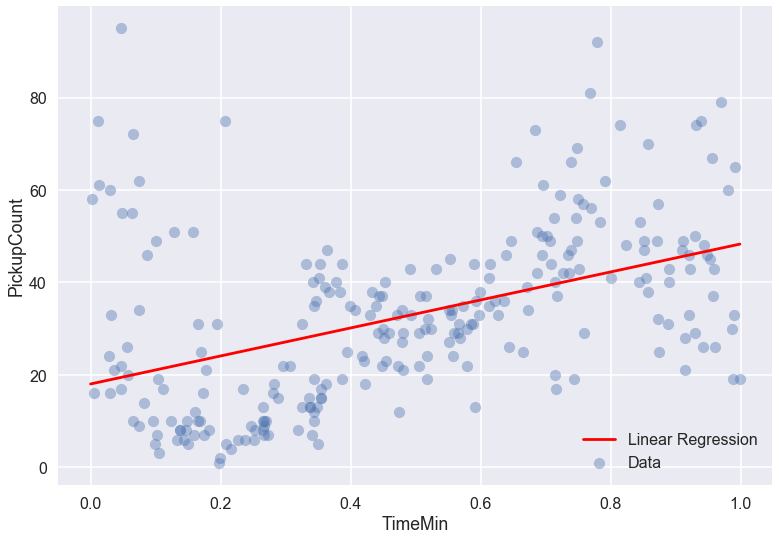

In [38]:
xPrime = np.arange(0, 1, .001)
xPrime = sm.add_constant(xPrime)
yHat = trainLinModel.predict(xPrime)

fig, ax = plt.subplots(1)
sns.regplot(trainDf["TimeMin"], trainDf["PickupCount"], fit_reg = False, scatter_kws={'alpha':0.4}, label="Data")
ax.plot(xPrime[:,1], yHat, label="Linear Regression", color="red")
ax.set_xlabel("Time in Day")
ax.legend()

## <span style="color:red;"> Regression on Test Data </span>

In [41]:
# Generate linear regression model

# Add constant to data
xConst = sm.add_constant(testDf["TimeMin"])
testLinModel = sm.OLS(testDf["PickupCount"], xConst).fit()
print(testLinModel.summary())


                            OLS Regression Results                            
Dep. Variable:            PickupCount   R-squared:                       0.252
Model:                            OLS   Adj. R-squared:                  0.251
Method:                 Least Squares   F-statistic:                     336.1
Date:                Mon, 25 Sep 2017   Prob (F-statistic):           6.35e-65
Time:                        12:25:56   Log-Likelihood:                -4228.2
No. Observations:                1000   AIC:                             8460.
Df Residuals:                     998   BIC:                             8470.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         16.6116      1.053     15.774      0.0

In [43]:
testLinModel.params

const      16.611597
TimeMin    34.285125
dtype: float64

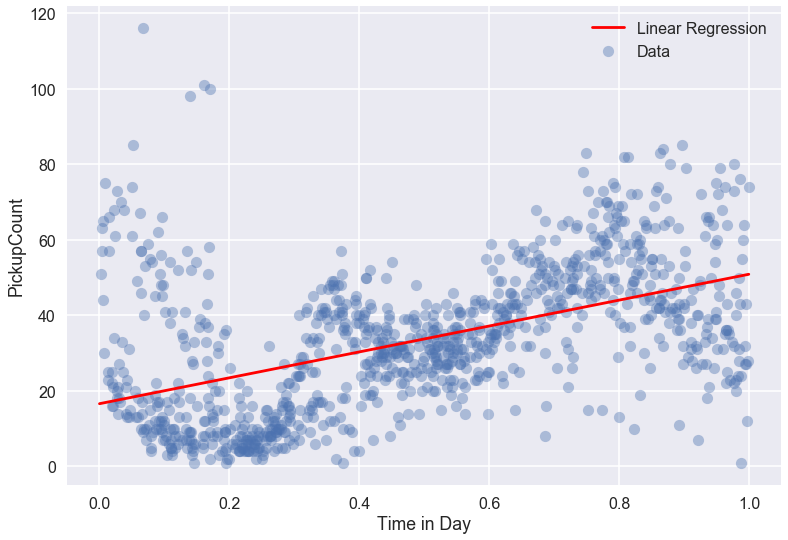

In [44]:
xPrime = np.arange(0, 1, .001)
xPrime = sm.add_constant(xPrime)
yHat = testLinModel.predict(xPrime)

fig, ax = plt.subplots(1)
sns.regplot(testDf["TimeMin"], testDf["PickupCount"], fit_reg = False, scatter_kws={'alpha':0.4}, label="Data")
ax.plot(xPrime[:,1], yHat, label="Linear Regression", color="red")
ax.set_xlabel("Time in Day")
ax.legend()

# Part (c): Polynomial Regression

We proceed to higher-order polynomial models for regression:

- By visual inspection, what polynomial degree do you think would provide the best fit for the data?

- At the start of this assignment, we had advised you to normalize the time predictor in the training and test sets to a value in [0,1], and noted that this would be helpful in fitting polynomial regression models. Had the time predictor not been normalized, what difficulties in implementing polynomial regression may have occurred?

- Fit polynomial regression models of degrees 2, 3, 10, 25 and 50 to the training set, and generate visualizations of the fitted models (in the same figure, plot the predicted value from all models as a function of time). 

- Evaluate the $R^2$ value of the fitted models on both the training and test sets. Does a high training $R^2$ value necessarily indicate a high test $R^2$ value? How do the test $R^2$ values from the different polynomial models compare with the test $R^2$ from simple linear regression in Part (b), and the best test $R^2$ from k-NN regression in Part (a)?

- Generate residual plots for the different polynomial regression models (plot of residuals on training set vs. time). How does the increase in polynomial degree effect the residual plots?

*Hint:* You may use the `PolynomialFeatures` class to include polynomial terms in the regression model.

In [ ]:
# <span style="color:red;"> Solution to Part (c) </span>

# Part (d): Summarize Results
In a brief paragraph (8 or fewer sentences), summarize which of the models seen above you would choose to predict the number of taxi cab pick-ups at any specific time of day.  Be sure to explain your choice. Interpret the model you choose, including which predictors are significant and provide and interpret the CIs for their coefficients (if you choose a regression model). How well does you model predict the number of taxi cab pick-ups?  How would you improve this model even further?  Feel free to refer to visual(s) above or provide a new one to make your case.



In [20]:
# <span style="color:red;"> Solution to Part (d) </span>

---- 


# APCOMP209a - Homework Question

Read Sections 1 and 2 of this [paper](https://www.researchgate.net/profile/Roberto_Togneri/publication/45094554_Linear_Regression_for_Face_Recognition/links/09e4150d243bd8b987000000/Linear-Regression-for-Face-Recognition.pdf). 

Briefly, we have a number of cleaned images of people's faces. The model leverages the concept that "patterns from a single-object class lie on a linear subspace" and the fact that linear regression can be thought of as an orthogonal projection of the response vector (Y) onto the subspace spanned by the columns of the predictor matrix (X).

### Question 1
Consider a space in $\mathbb{R}^5$, with two subspaces $S_0 \subset \mathbb{R}^5$ and $S_1 \subset \mathbb{R}^5$. For simplicity, let us consider the case where the subspace $S_0$ is spanned by the vectors $v_{00} = [1,0,0,0,0]^T$, $v_{01} =[0,1,0,0,0]^T$ and the subspace $S_1$ is spanned by the vectors $v_{10} = [0,0,0,1,0]^T$ and $v_{11} = [0,0,0,0,1]^T$. 

Now let us assume that we have a dataset that consists of labeled vectors in subspaces $S_0$ and $S_1$ respectively. Our task here is to use the data in the training dataset to classify an unknown vector into either $S_0$ or $S_1$.

Let us consider the case where we construct a predictive matrix $\mathbf{X}$ from the 'training' data for which we know the labels (note: is not meant to match $S_0$ and $S_1$ above).

```
dataset = np.array([
            [1,0,0,0,0],
            [1,1,0,0,0],
            [0,0,0,1,1],
            [0,0,0,1,0],
            ])
labels = np.array([0,0,1,1])
```

(Briefly notice that the training data probably doesn't consist of vectors that are orthonormal in spanning $S_0$ or $S_1$).

And we have an unknown vector, for which we want clasify as either a noisy example of a vector in either $S_0$ or $S_1$: ```y_0 = np.array([2,10,1,0,0])```.

In [ ]:
# starter code
dataset = np.array([
            [1,0,0,0,0],
            [1,1,0,0,0],
            [0,0,0,1,1],
            [0,0,0,1,0],
            ])
labels = np.array([0,0,1,1])
y_0 = np.array([2,10,1,0,0])

#### Question 1a
Recall the solution for the Least Squares problem and the 'hat' matrix $\mathbf{H}$. Consider the case when $Y$ lies in the same subspace as the columns of $\mathbf{X}$. In this case, how accurate should the prediction of $\hat{Y}$ be?

#### Question 1b
Given the projection of $Y$ onto the space spanned by the columns of the X matrix. We can analyse the significance of the different predictor vectors (i.e. the building blocks that are used to reconstrct the $\hat{Y}$ vector). Discuss how this may help one when analysing a classification decision by the model.

#### Question 1c
As discussed in the linked paper, we have data that has vectors that are classified into one subspace or another (our training dataset). We can use the projection interpretation of linear regression to make a classification decision of a new (unseen) vector into either $S_0$ or $S_1$. In other words, construct X matrices from the known vectors, and project the unknown vector onto the subspaces spanned by the various X matrices using the "hat" interpretation of linear regression. To do classification, we can calculate the minimum euclidean distance ($L_2$ norm) between the original vector and the projection. Use this method to classify ```y_0``` as belonging to either $S_0$ or $S_1$.

**Feel free to run this same example on the face data presented in the paper - you will be doing this for next week's homework regardless**

#### Question 1d (unrelated to the parts above)

Explicitly derive the relationship between the F-statistic (from the usual F test) and the $R^2$ measure in multiple linear regression (i.e. write the F-statistic of a multiple linear regression model in terms of the $R^2$ of the same model).